# **Final Project**
Milana Aligaziyeva, Dilnaza Maratova IT-2101

# **DeepFake and FaceSwap**

# Load pretrained model of DeepFake

Here is the link to github repositories

In [1]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model
%cd first-order-model
!pip install ffmpeg-python
!pip install imageio
!pip install imageio-ffmpeg

Cloning into 'first-order-model'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 337 (delta 15), reused 19 (delta 7), pack-reused 306
Receiving objects: 100% (337/337), 72.16 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (173/173), done.
/content/first-order-model
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 40.3 MB/s eta 0:00:00


# Set path to Google Drive to extract datasets (photos, videos and important libraries)

Link to our Google Drive folder: https://drive.google.com/drive/folders/1Jw1Qub0ar3BmAp3MvOhGADZfMlkh9Ggp?usp=share_link

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import main modules

In [3]:
import tensorflow as tf
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Load checkpoints from external sources of pretrained models

In [4]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', 
                            checkpoint_path='/content/gdrive/My Drive/hello/vox-cpk.pth.tar')

#Set path to the source picture and video

In [5]:
photo = "hello/solar.png" #@param {type:"string"}
video = "hello/dilnaz.mp4" #@param {type:"string"}  

In [6]:
from demo import make_animation
from skimage import img_as_ubyte
 
picture = imageio.imread('/content/gdrive/My Drive/'+photo)
vid = imageio.get_reader('/content/gdrive/My Drive/'+video)
 
fps = vid.get_meta_data()['fps']

result_video = []
try:
    for im in vid:
        result_video.append(im)
except RuntimeError:
    pass
vid.close()
 
picture = resize(picture, (256, 256))[..., :3]
result_video = [resize(frame, (256, 256))[..., :3] for frame in result_video]
 
predictions = make_animation(picture, result_video, generator, kp_detector, relative=True,
                             adapt_movement_scale=True)


  0%|          | 0/1045 [00:00<?, ?it/s]

In [7]:
def show(source, driving, generated=None):
    figure = plt.figure(figsize=(8 + 4 * (generated is not None), 6))
 
    imgs = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        imgs.append([im])
 
    ani = animation.ArtistAnimation(figure, imgs, interval=50, repeat_delay=1000)
    plt.close()
    return ani

In [8]:
imageio.mimsave('../result.mp4', [img_as_ubyte(frame) for frame in predictions])

In [9]:
HTML(show(picture, result_video, predictions).to_html5_video())


# Face Swap

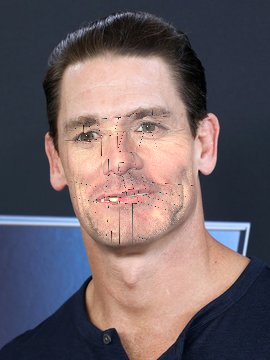

In [10]:
from google.colab.patches import cv2_imshow
import cv2
import dlib
import time

#Exctracting images from Google Drive
def dis_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index


img = cv2.imread("/content/gdrive/My Drive/hello/jim.jpg")
img_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gr)
img2 = cv2.imread("/content/gdrive/My Drive/hello/john.jpg")
img2_gr = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


detector = dlib.get_frontal_face_detector() # using the dlib library to detect the facial landmark points of the images
predictor = dlib.shape_predictor("/content/gdrive/My Drive/hello/shape_predictor_68_face_landmarks.dat")
h, w, channels = img2.shape
img2_new_face = np.zeros((h, w, channels), np.uint8)

# Detecting the landmarks of the first(source) image
pic = detector(img_gr)
for face in pic:
    landmarks = predictor(img_gr, face)
    lpoints = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        lpoints.append((x, y))

    points = np.array(lpoints, np.int32)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)
    face_image_1 = cv2.bitwise_and(img, img, mask=mask)


# Performing Delaunay triangulation

# With the help of landmark points, we divide the first 
# face into triangles using delaunay triangulation method
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(lpoints)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        i_pt1 = np.where((points == pt1).all(axis=1))
        i_pt1 = dis_nparray(i_pt1)
        i_pt2 = np.where((points == pt2).all(axis=1))
        i_pt2 = dis_nparray(i_pt2)
        i_pt3 = np.where((points == pt3).all(axis=1))
        i_pt3 = dis_nparray(i_pt3)

        if i_pt1 is not None and i_pt2 is not None and i_pt3 is not None:
            triangle = [i_pt1, i_pt2, i_pt3]
            indexes_triangles.append(triangle)

# Then we are moving onto the second face
pic2 = detector(img2_gr)
for face in pic2:
    landmarks = predictor(img2_gr, face)
    lpoints2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        lpoints2.append((x, y))


    points2 = np.array(lpoints2, np.int32)
    convexhull2 = cv2.convexHull(points2)

lsm = np.zeros_like(img_gr)
ls_new_face = np.zeros_like(img2)

# We are performing triangulation of the destination image by using the same patterns of the first image.

# Using the indexes of each triangle of the source image and reconstruct them in the second image.
for triangle_index in indexes_triangles:
    # Triangulation of the source face
    tr1_pt1 = lpoints[triangle_index[0]]
    tr1_pt2 = lpoints[triangle_index[1]]
    tr1_pt3 = lpoints[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    crpe_trngl = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lsm, tr1_pt1, tr1_pt2, 255)
    cv2.line(lsm, tr1_pt2, tr1_pt3, 255)
    cv2.line(lsm, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lsm)

    # Triangulation of destination image
    tr2_pt1 = lpoints2[triangle_index[0]]
    tr2_pt2 = lpoints2[triangle_index[1]]
    tr2_pt3 = lpoints2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Triangles exctraction and warping
# Then we exctract each triangle from the source image and move them to the 
# correspondent regions on the destination image. However, in order for the swapping 
# to be more accurate, it is necessary to warp the triangles.
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    wrpd_trngl = cv2.warpAffine(crpe_trngl, M, (w, h))
    wtriangle = cv2.bitwise_and(wrpd_trngl, wrpd_trngl, mask=cropped_tr2_mask)
    
    #Then we put the warped triangles together one by one so the source face is accurately reconstructed to fit the second face.
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    wrpd_trngl = cv2.bitwise_and(wrpd_trngl, wrpd_trngl, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, wrpd_trngl)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

    # Face swapping
# Lastly, we take the exctracted face of the first image and put it into the corresponding area of the second image's face.
img2_face_mask = np.zeros_like(img2_gr)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


img2_head = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head, img2_new_face)

(x, y, w, h) = cv2.boundingRect(convexhull2)
cntr_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

# However the swapped faces might look ridiculous since the colors of both faces might not fit each other,
# that is why we are using a builit-in function in OpenCV that does seamless cloning

seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, cntr_face2, cv2.NORMAL_CLONE)

cv2_imshow(seamlessclone)
cv2.waitKey(0)
cv2.destroyAllWindows()